In [1]:
# imports
import torch
from stock_dataloader import create_stock_dataloader
from lstm import StockLSTM
from transformer import StockTransformer
from model_trainer import train_model, save_model, load_model
from evaluation import evaluate_model
from plots import plot_time_series

In [2]:
# Create dataloader

# Hyperparameters
SEQ_LEN = 100           # default 100; window for set of time-series data points
BATCH_SIZE = 32         # default 32; increase if GPU mem allows
STOCKS_PER_BUCKET = 5   # default 13; number of stocks per category bucket
TRAIN_PER_BUCKET = 3    # default 10; number of training stocks per category bucket

stock_csv = 'selected_stocks_data.csv'
metadata_csv = 'selected_stocks_quality.csv'
stock_dataloader = create_stock_dataloader(stock_csv, metadata_csv, seq_len=SEQ_LEN, batch_size=BATCH_SIZE,
                                           stocks_per_bucket=STOCKS_PER_BUCKET, train_per_bucket=TRAIN_PER_BUCKET)
train_dataloader = stock_dataloader['train_loader']
eval_dataloader = stock_dataloader['eval_loader']
train_tickers = stock_dataloader['train_tickers']
eval_tickers = stock_dataloader['eval_tickers']

Loading stock data...

Splitting top 5 stocks per category...
✅ Train: 15 tickers | Eval: 10 tickers
Eval stocks: ['increasing: ARLP (q=1.1925)', 'increasing: COKE (q=0.8397)', 'decreasing: FORR (q=0.7293)', 'decreasing: IART (q=0.5110)', 'one_spike: CME (q=43.1664)', 'one_spike: CSCO (q=41.2288)', 'two_spikes: DOX (q=44.1868)', 'two_spikes: CSQ (q=43.7714)', 'stagnant: KMB (q=0.8253)', 'stagnant: CHY (q=0.7687)']

Creating training sequences...

✅ Data loaded: 15 train tickers, 10 eval tickers


In [3]:
# Create LSTM Model

# Hyperparameters
INPUT_SIZE = 1          # default 1; based on data
HIDDEN_SIZE = 64        # default 64; analogous to D_MODEL; increase to 128 if underfitting
NUM_LAYERS = 2          # default 2, re-evaluate if underfitting
DROP_OUT = 0.2          # default 0.2; re-evaluate if overfitting

lstm_model = StockLSTM(input_size=INPUT_SIZE,
                  hidden_size=HIDDEN_SIZE,
                  num_layers=NUM_LAYERS,
                  dropout=DROP_OUT)

In [4]:
# Create Transformer Model

# Hyperparameters
INP_DIM = 1             # default 1; based on data
D_MODEL = 64            # default 64; analogous to HIDDEN_SIZE; re-evaluate if underfitting
N_HEADS = 4             # default 4; 64/4 = 16 - standard ratio
N_LAYERS = 3            # default 3; re-evaluate if underfitting
DIM_FEEDFORWARD = 256   # default 256; 4x D_MODEL is standard
DROPOUT = 0.1           # default 0.1; re-evaluate if overfitting
OUTPUT_DIM = 1          # default 1; based on data - next-day closing price
MAX_LEN = 500           # default 500; should be > SEQ_LEN

transformer_model = StockTransformer(inp_dim=INP_DIM,
                         d_model=D_MODEL,
                         n_heads=N_HEADS,
                         n_layers=N_LAYERS,
                         dim_feedforward=DIM_FEEDFORWARD,
                         dropout=DROPOUT,
                         output_dim=OUTPUT_DIM,
                         max_len=MAX_LEN)

In [5]:
# Train model

# Hyperparameters
NUM_EPOCHS = 50         # default 50; increase if underfitting
LEARNING_RATE = 0.001   # default 0.001; drop to 3e-4 if unstable
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

model_choice = 'Transformer'   # Select 'LSTM' or 'Transformer'
model_save_name = f'Stock{model_choice}_ModelMini_LayerNorm'
model_save = True
model_load = True

print(f"Training {model_choice} model on device: {DEVICE}")
if model_choice == 'LSTM':
    if model_load:
        try:
            trained_model = load_model(f'models\{model_save_name}')
        except FileNotFoundError as e:
            print(e)
            trained_model = train_model(lstm_model, train_dataloader, num_epochs=NUM_EPOCHS, learning_rate=LEARNING_RATE, device=DEVICE)
    else:
        trained_model = train_model(lstm_model, train_dataloader, num_epochs=NUM_EPOCHS, learning_rate=LEARNING_RATE, device=DEVICE)
        if model_save:
            save_model(trained_model, save_name=model_save_name)
elif model_choice == 'Transformer':
    if model_load:
        try:
            trained_model = load_model(f'models\{model_save_name}')
        except FileNotFoundError as e:
            print(e)
            trained_model = train_model(transformer_model, train_dataloader, num_epochs=NUM_EPOCHS, learning_rate=LEARNING_RATE, device=DEVICE)
    else:
        trained_model = train_model(transformer_model, train_dataloader, num_epochs=NUM_EPOCHS, learning_rate=LEARNING_RATE, device=DEVICE)
        if model_save:
            save_model(trained_model, save_name=model_save_name)


Training Transformer model on device: cuda
✅ Model loaded: models\StockTransformer_ModelMini_LayerNorm


In [6]:
# Evaluate model
evaluate_model(trained_model, eval_dataloader, device=DEVICE)

c:\Users\jwcabot\.conda\envs\lstm-env\Lib\site-packages\torch\nn\modules\transformer.py:720: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  return torch._transformer_encoder_layer_fwd(


0.07013329781769231

plot_tickers: ['AMZN', 'EBAY', 'COKE']
plot_df columns: ['AMZN', 'EBAY', 'COKE']
plot_df shape: (5030, 3)


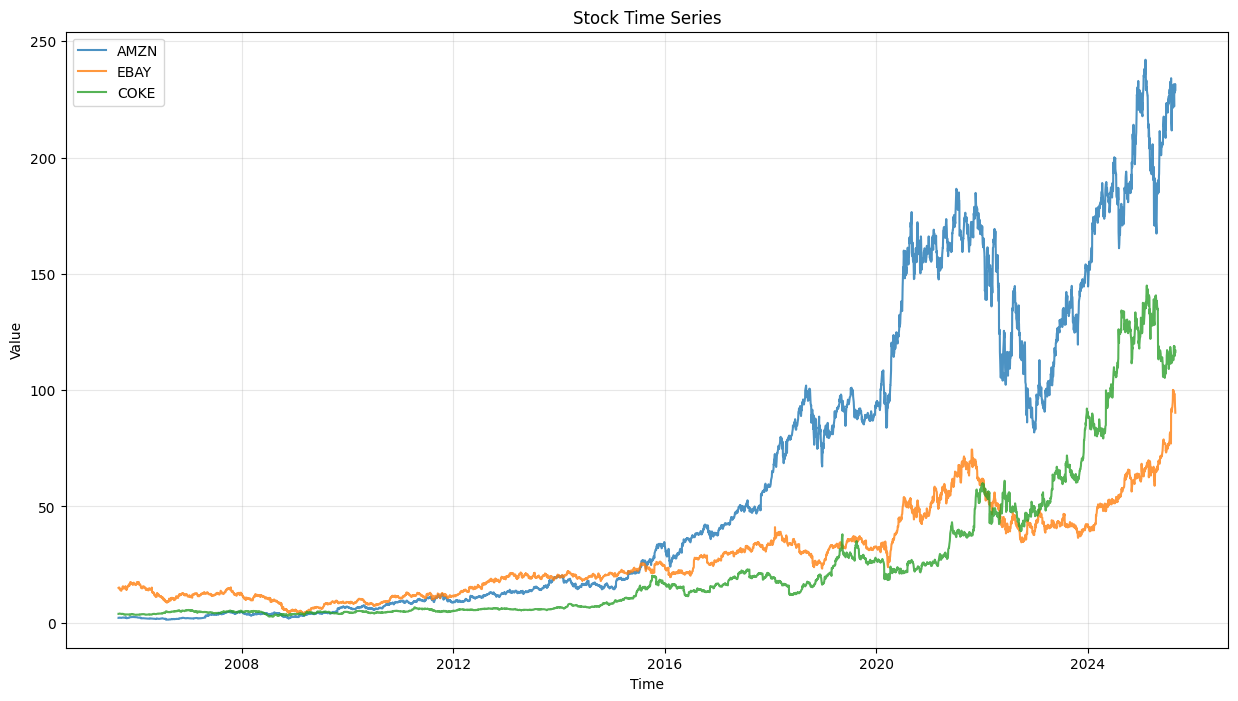

plot_tickers: ['AMZN', 'EBAY', 'COKE']
plot_df columns: ['AMZN', 'EBAY', 'COKE']
plot_df shape: (5030, 3)


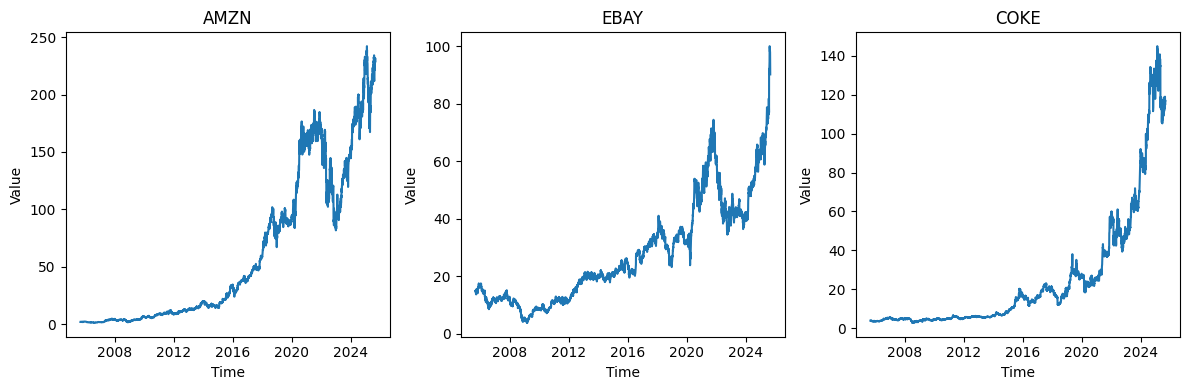

In [7]:
# Plot time-series

# From CSV
plot_time_series("selected_stocks_data.csv", tickers=['AMZN', 'EBAY', 'COKE'])

# Separate plots
plot_time_series("selected_stocks_data.csv", tickers=['AMZN', 'EBAY', 'COKE'], separate=True)

batch_y dtype: torch.float32
batch_y shape: torch.Size([20, 1])
batch_y sample values: [[0.92803526]
 [0.9251683 ]
 [0.92803526]
 [0.9309022 ]
 [0.9261239 ]]
batch_y min/max: 0.921196699142456 0.9414497017860413
Is batch_y float? True
plot_tickers: ['Actual']
plot_df columns: ['Actual']
plot_df shape: (10000, 1)


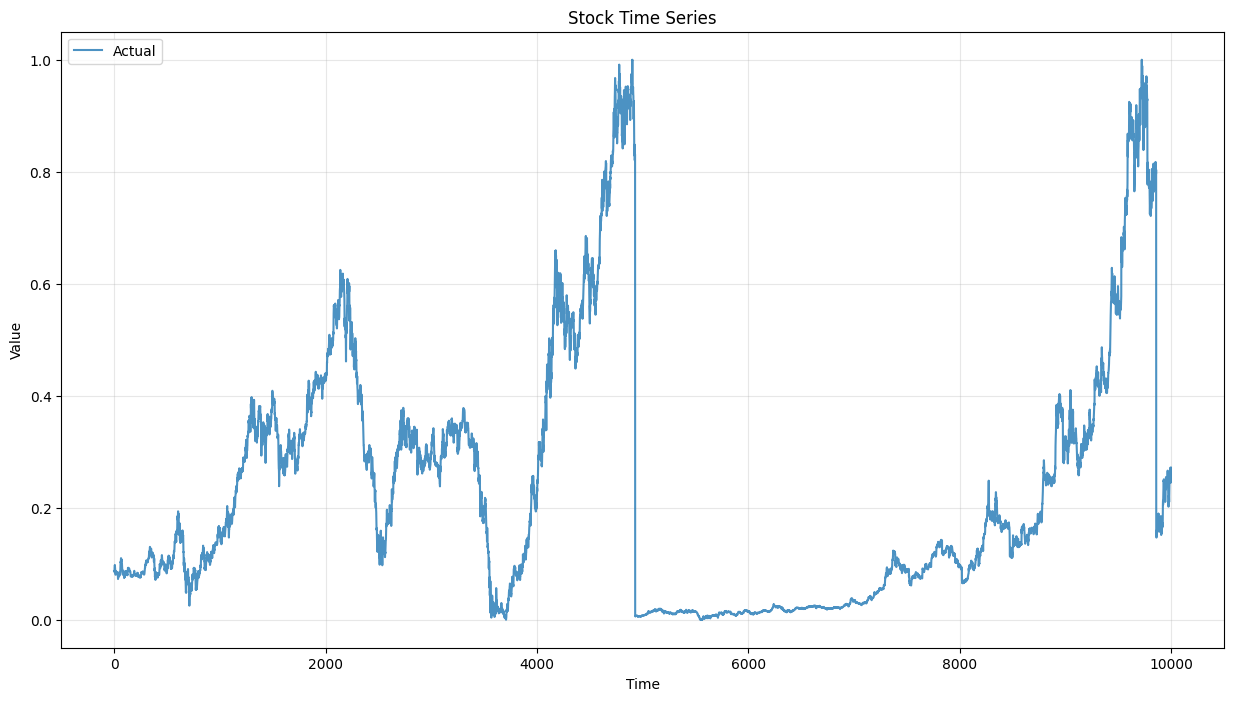

plot_tickers: ['Predicted']
plot_df columns: ['Predicted']
plot_df shape: (10000, 1)


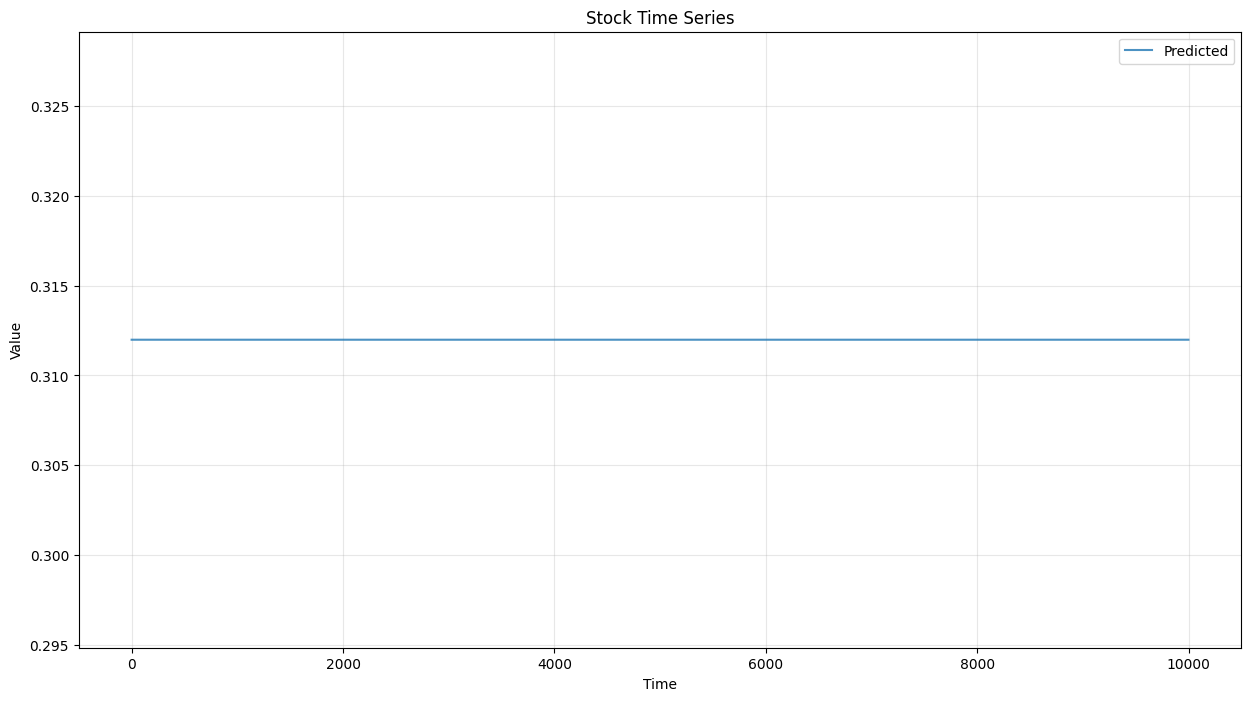

plot tickers before validation: ['Actual', 'Predicted']
plot_df columns: ['Actual', 'Predicted']
plot_tickers: ['Actual', 'Predicted']
plot_df columns: ['Actual', 'Predicted']
plot_df shape: (10000, 2)


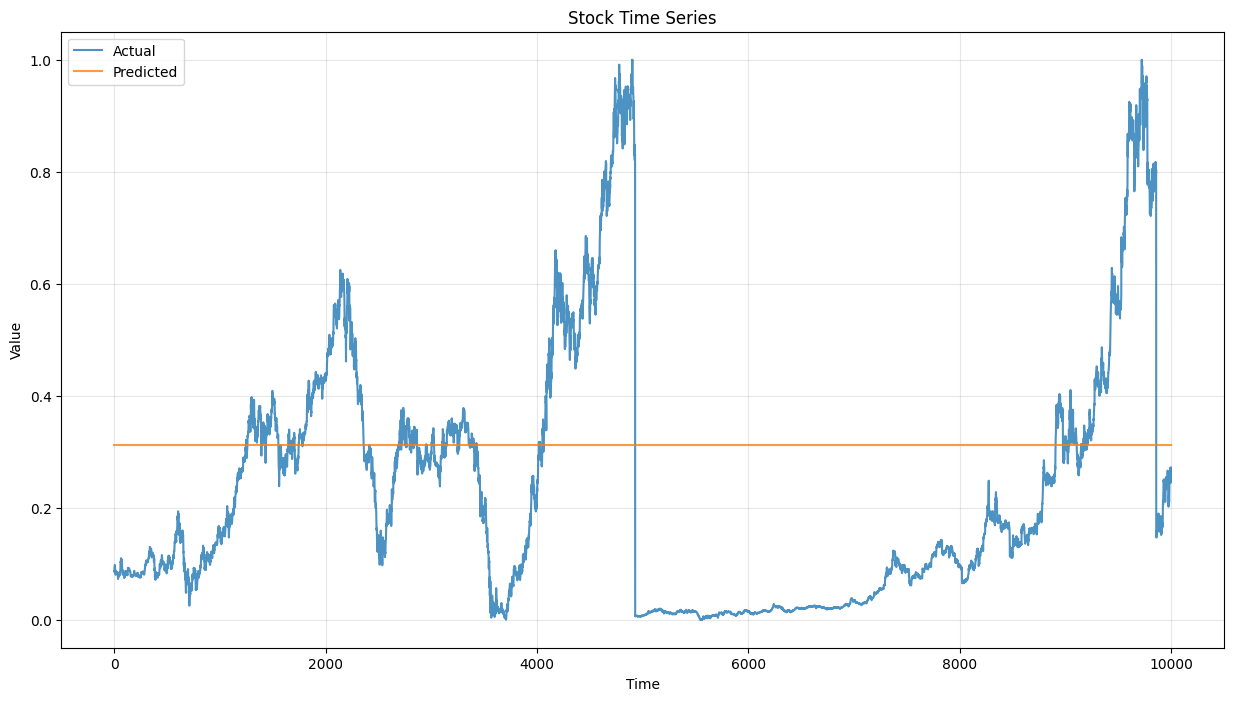

['ARLP', 'COKE', 'FORR', 'IART', 'CME', 'CSCO', 'DOX', 'CSQ', 'KMB', 'CHY']


In [ ]:
import numpy as np
trained_model.eval()
trained_model.to(DEVICE)

predictions = []
actuals = []

with torch.no_grad():
    for batch_x, batch_y in eval_dataloader:
        batch_x, batch_y = batch_x.to(DEVICE), batch_y.float().to(DEVICE)
        pred = trained_model(batch_x)  # Shape: [batch_size, 1]
        predictions.append(pred.cpu())
        actuals.append(batch_y.cpu())

# 2. Concatenate all predictions
all_predictions = torch.cat(predictions).squeeze().numpy()  # 1D array
all_actuals = torch.cat(actuals).squeeze().numpy()          # 1D array

# 3. Plot model vs actual
plot_time_series(all_actuals, tickers=["Actual"])
plot_time_series(all_predictions, tickers=["Predicted"])

# 4. Plot TOGETHER (1D tensor stacking)
combined = np.stack([all_actuals, all_predictions], axis=0)  # [2, N]
plot_time_series(combined, tickers=["Actual", "Predicted"])